# Imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_bvp
from scipy.stats import multivariate_normal as mvn
from matplotlib import cm, ticker


### Functions

## Task 1

In [36]:
## PDF:
w = np.array([0.5, 0.2, 0.3])
mu = np.array([[0.35, 0.38], [0.68, 0.25], [0.56, 0.64]])
sigma = np.array([[[0.01, 0.004], [0.004, 0.01]], [[0.005, -0.003], [-0.003, 0.005]], [[0.008, 0], [0, 0.004]]])

## Fourier Vector Grid:
num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(np.arange(num_k_per_dim), np.arange(num_k_per_dim))
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T 

## Grid:
L_list = np.array([1.0, 1.0])
N = 100
grids_x, grids_y = np.meshgrid(np.linspace(0, L_list[0], N), np.linspace(0, L_list[1], N))
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (N-1)
dy = 1.0 / (N-1)  # the resolution of the grids

### define parameters
dt, t_end = 0.1, 10
tsteps = int(t_end/dt)
x0 = np.array([0.3, 0.3])
t = np.linspace(0, t_end, tsteps)

np.seed = 5
init_u_traj = np.tile(np.array([0.15, 0.0]), reps=(tsteps,1))
init_u_traj = (np.random.randn(tsteps, 2)-0.5)*0.1

f1, f2 = 0.1, 5
cosine_signal = np.cos(f1*t) + np.cos(f2*t)
init_u_traj = np.tile(cosine_signal[:, np.newaxis], reps=(1, 2))*0.01

Q_x = 0.01
R_u = np.diag([0.001, 0.001])

Q_z = np.diag([0.005, 0.005, 0.005, 0.005])
R_v = np.diag([0.005, 0.005])

lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)

In [37]:
#### Function Definitions
## Mixture PDF
def pdf(x):
    return w[0] * mvn.pdf(x, mu[0], sigma[0]) + \
           w[1] * mvn.pdf(x, mu[1], sigma[1]) + \
           w[2] * mvn.pdf(x, mu[2], sigma[2])

## get fourier coefficients
def get_coefficients(pdf, dx, dy, ks, L_list, grids):
    # Compute the coefficients
    coefficients = np.zeros(ks.shape[0])  # number of coefficients matches the number of index vectors
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the fourier basis function over all the grid cells
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  # we use NumPy's broadcasting feature to simplify computation
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)  # normalization term
        fk_vals /= hk

        # step 2: evaluate the spatial probabilty density function over all the grid cells
        pdf_vals = pdf(grids)  # this can computed ahead of the time

        # step 3: approximate the integral through the Riemann sum for the coefficient
        phik = np.sum(fk_vals * pdf_vals) * dx * dy
        coefficients[i] = phik
    return coefficients

## get trajectory coefficients
def get_traj_coefficients(dx, dy, ks, L_list, grids, s_traj):
    if len(s_traj.shape) == 1:
        s_traj = s_traj.reshape(-1, 1)
    traj_coefficients = np.zeros(ks.shape[0])
    
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the basis function over the trajectory
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * s_traj), axis=1)
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        fk_vals /= hk

        # step 2: approximate the integral through the Riemann sum for the coefficient
        ck = np.sum(fk_vals) * dt / (tsteps * dt)
        traj_coefficients[i] = ck
    return traj_coefficients

## reconstruct the pdf
def reconstruct_pdf(coefficients, ks, L_list, grids, dx, dy):
    pdf_recon = np.zeros(grids.shape[0])
    for i, (phik, k_vec) in enumerate(zip(coefficients, ks)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk

        pdf_recon += phik * fk_vals
    return pdf_recon

## reconstruct the trajectory
def reconstruct_traj(traj_coefficients, ks, L_list, dx, dy):
    phi_recon = np.zeros(grids.shape[0])
    for i, (ck, k_vec) in enumerate(zip(traj_coefficients, ks)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk

        phi_recon += ck * fk_vals
    return phi_recon

## ergodic loss:
def ergodic_metric(coefficients, traj_coefficients):
    # Finally, we compute the erogdic metric
    erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coefficients))
    return erg_metric

coefficients = get_coefficients(pdf, dx, dy, ks, L_list, grids)
Z = pdf(grids)

In [38]:
#### LQR Functions
def dyn(xt, ut):
    xdot = np.array([ut[0],
                     ut[1]])
    return xdot


def get_A(t, xt, ut):
    A = np.array([[0, 0],
                  [0, 0]])
    return A


def get_B(t, xt, ut):
    B = np.array([[1, 0],
                  [0, 1]])
    return B


def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    return xt_new


def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 2))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new.copy()
        xt = xt_new.copy()
    return x_traj


def a(t, xt, ut, coefficients_difference):
    a_vec = np.zeros((ks.shape[0], 2))
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the basis function over the trajectory
        dfk_vals = np.array([-np.sin(np.pi * k_vec[0]/L_list[0] * xt[0])*np.cos(np.pi * k_vec[1]/L_list[1]* xt[1])*np.pi*k_vec[0]/L_list[0],
                            -np.cos(np.pi * k_vec[0]/L_list[0] * xt[0])*np.sin(np.pi * k_vec[1]/L_list[1]* xt[1])*np.pi*k_vec[1]/L_list[1]])
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        dfk_vals /= hk
        a_vec[i] = lamk_list[i] * 2 *(coefficients_difference[i])*dfk_vals/t_end
       
    return Q_x*np.sum(a_vec, axis=0)

def b(t, xt, ut):
    dvec = R_u @ ut
    return dvec


def get_J(x_traj, u_traj):
    J = 0
    J += Q_x*ergodic_metric(coefficients, get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj))
    for t in range(tsteps):
        J += 0.5 * u_traj[t].T @ R_u @ u_traj[t]*dt

    return J

In [40]:
def ilqr_iter(x0, u_traj, traj_coefficients, coefficients_difference):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 2, 2))
    B_list = np.zeros((tsteps, 2, 2))
    a_list = np.zeros((tsteps, 2))
    b_list = np.zeros((tsteps, 2))
    
    for t_idx in range(tsteps):
        t = t_idx * dt
        t_idx = np.clip(t_idx, 0, tsteps-1)
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = a(t, x_traj[t_idx], u_traj[t_idx], coefficients_difference)
        b_list[t_idx] = b(t, x_traj[t_idx], u_traj[t_idx])
    
    
    def zp_dyn(t, zp):
        t_idx = (t/dt).astype(int)
        t_idx = np.clip(t_idx, 0, tsteps-1)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        M_11 = At
        M_12 = -Bt@np.linalg.inv(R_v)@Bt.T
        M_21 = -Q_z
        M_22 = -At.T
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        m_1 = -Bt @ np.linalg.inv(R_v) @ bt
        m_2 = -at
        dyn_vec = np.hstack([m_1, m_2])
        
        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((4, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        return np.array([zp_0[0], zp_0[1], zp_T[2], zp_T[3]])

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    tlist = np.arange(tsteps) * dt
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((4,tsteps)),
        max_nodes=100
    )
    zp_traj = res.sol(tlist).T
    
    z_traj = zp_traj[:,:2]
    p_traj = zp_traj[:,2:]

    v_traj = np.zeros((tsteps, 2))
    DJ_vt = 0
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]
        
        vt = -np.linalg.inv(R_v) @ (Bt.T @ pt + bt)
        v_traj[_i] = vt
        
        DJ_vt += at.T @ zt + bt.T @ vt
    
    return v_traj, DJ_vt

In [41]:
#### Start iLQR iterations here
u_traj = init_u_traj.copy()
x_initial = traj_sim(x0, u_traj)
cost_to_go = np.array(0)
for iter in range(150):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)
    cost_to_go = np.append(cost_to_go, get_J(x_traj, u_traj))
    traj_coefficients = get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj)
    coefficients_difference = traj_coefficients - coefficients
    
    # check for convergence
    """
    if np.abs(cost_to_go[-1] - cost_to_go[-2]) < 1e-8:
        break
        """
    # get descent direction
    v_traj, DJ_vt = ilqr_iter(x0, u_traj, traj_coefficients, coefficients_difference)
    
    # Armijo line search parameters
    gamma = 0.0124 # initial step size
    alpha = 1e-02
    beta = 0.5
    
    ### Implement Armijo line search here to update step size gamma
    J_new = get_J(traj_sim(x0, u_traj + gamma*v_traj), u_traj + gamma*v_traj)
    while J_new > cost_to_go[-1] + alpha*gamma*DJ_vt:
        gamma = beta*gamma
        J_new = get_J(traj_sim(x0, u_traj + gamma*v_traj), u_traj + gamma*v_traj)
    
    # update control for the next iteration
    u_traj += gamma * v_traj #+ gamma* 0.01*np.random.randn(tsteps, 2)
    print('Iteration:', iter, 'Cost:', cost_to_go[-1], 'Step Size:', gamma)

cost_to_go[0] = cost_to_go[1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 2

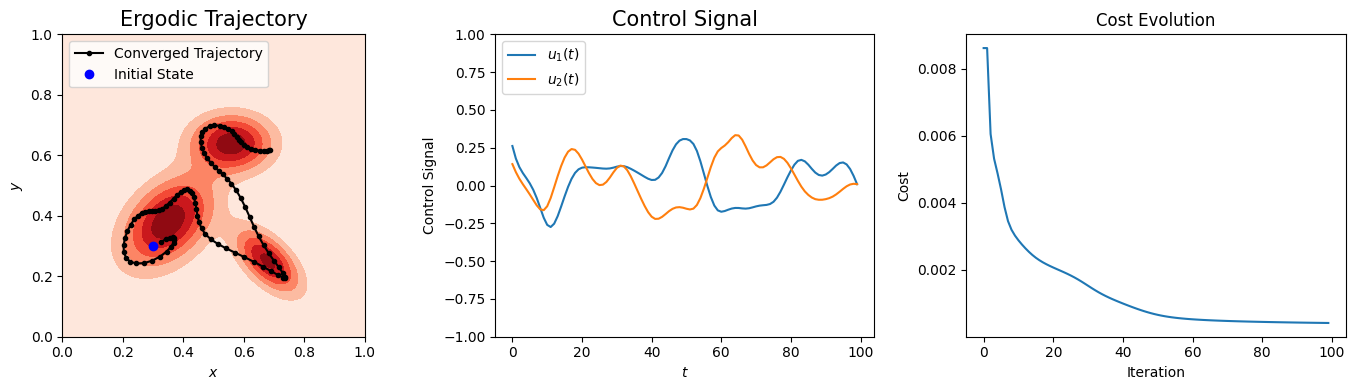

In [ ]:
#### Plot everything
phi_recon = reconstruct_pdf(get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj), ks, L_list, grids, dx, dy)

# visualize trajectory
size = 4
fontsize_plots = 15
fig, ax = plt.subplots(1, 3, figsize=(size*3.5, size))

ax[0].set_title('Ergodic Trajectory', fontsize=fontsize_plots)
ax[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='o', color='k', label='Converged Trajectory', markersize=3)
ax[0].contourf(grids_x, grids_y, Z.reshape(grids_x.shape), cmap='Reds', levels=5, alpha=1)
ax[0].plot(x0[0], x0[1], 'bo', label='Initial State')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_aspect('equal')
ax[0].legend(loc='upper left')


ax[1].set_title('Control Signal', fontsize=fontsize_plots)
ax[1].plot(u_traj[:,0], color='C0', label='$u_1(t)$')
ax[1].plot(u_traj[:,1], color='C1', label='$u_2(t)$')
ax[1].set_xlabel('$t$')
ax[1].set_ylim([-1, 1])
ax[1].set_ylabel('Control Signal')
ax[1].legend(loc='upper left')

ax[2].set_title('Cost Evolution')
ax[2].plot(cost_to_go[1:], color='C0', label='Final Cost: {:.2f}'.format(cost_to_go[-1]))
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Cost')

"""
ax[3].set_aspect('equal')
ax[3].set_xlim(0.0, L_list[0])
ax[3].set_ylim(0.0, L_list[1])
ax[3].set_title('Empirical Distribution')
ax[3].contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax[3].set_aspect('equal')
"""
plt.tight_layout()
plt.savefig('ergodic1.png')
plt.show()
plt.close()

## Task 2

In [58]:
## PDF:
w = np.array([0.5, 0.2, 0.3])
mu = np.array([[0.35, 0.38], [0.68, 0.25], [0.56, 0.64]])
sigma = np.array([[[0.01, 0.004], [0.004, 0.01]], [[0.005, -0.003], [-0.003, 0.005]], [[0.008, 0], [0, 0.004]]])

## Fourier Vector Grid:
num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(np.arange(num_k_per_dim), np.arange(num_k_per_dim))
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T 

## Grid:
L_list = np.array([1.0, 1.0])
N = 100
grids_x, grids_y = np.meshgrid(np.linspace(0, L_list[0], N), np.linspace(0, L_list[1], N))
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (N-1)
dy = 1.0 / (N-1)  # the resolution of the grids

### define parameters
dt, t_end = 0.1, 10
tsteps = int(t_end/dt)
x0 = np.array([0.3, 0.3, 0, 0])
t = np.linspace(0, t_end, tsteps)

np.seed = 1234
init_u_traj = np.tile(np.array([0.0125, 0.0125]), reps=(tsteps,1))
#init_u_traj = (np.random.randn(tsteps, 2)-0.5)

f1, f2 = 0.1, 5
cosine_signal = np.cos(f1*t) + np.cos(f2*t)
#init_u_traj = np.tile(cosine_signal[:, np.newaxis], reps=(1, 2))

Q_x = 0.2
R_u = np.diag([0.001, 0.001])

Q_z = np.diag([0.005, 0.005, 0.005, 0.005])
R_v = np.diag([0.005, 0.005])

lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)

In [59]:
#### Function Definitions
## Mixture PDF
def pdf(x):
    return w[0] * mvn.pdf(x, mu[0], sigma[0]) + \
           w[1] * mvn.pdf(x, mu[1], sigma[1]) + \
           w[2] * mvn.pdf(x, mu[2], sigma[2])

## get fourier coefficients
def get_coefficients(pdf, dx, dy, ks, L_list, grids):
    # Compute the coefficients
    coefficients = np.zeros(ks.shape[0])  # number of coefficients matches the number of index vectors
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the fourier basis function over all the grid cells
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  # we use NumPy's broadcasting feature to simplify computation
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)  # normalization term
        fk_vals /= hk

        # step 2: evaluate the spatial probabilty density function over all the grid cells
        pdf_vals = pdf(grids)  # this can computed ahead of the time

        # step 3: approximate the integral through the Riemann sum for the coefficient
        phik = np.sum(fk_vals * pdf_vals) * dx * dy
        coefficients[i] = phik
    return coefficients

## get trajectory coefficients
def get_traj_coefficients(dx, dy, ks, L_list, grids, s_traj):
    if len(s_traj.shape) == 1:
        s_traj = s_traj.reshape(-1, 1)
    traj_coefficients = np.zeros(ks.shape[0])
    s_traj = s_traj[:, :2]
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the basis function over the trajectory
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * s_traj), axis=1)
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        fk_vals /= hk

        # step 2: approximate the integral through the Riemann sum for the coefficient
        ck = np.sum(fk_vals) * dt / (tsteps * dt)
        traj_coefficients[i] = ck
    return traj_coefficients

## reconstruct the pdf
def reconstruct_pdf(coefficients, ks, L_list, grids, dx, dy):
    pdf_recon = np.zeros(grids.shape[0])
    for i, (phik, k_vec) in enumerate(zip(coefficients, ks)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk

        pdf_recon += phik * fk_vals
    return pdf_recon

## reconstruct the trajectory
def reconstruct_traj(traj_coefficients, ks, L_list, dx, dy):
    phi_recon = np.zeros(grids.shape[0])
    for i, (ck, k_vec) in enumerate(zip(traj_coefficients, ks)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk

        phi_recon += ck * fk_vals
    return phi_recon

## ergodic loss:
def ergodic_metric(coefficients, traj_coefficients):
    # Finally, we compute the erogdic metric
    erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coefficients))
    return erg_metric

coefficients = get_coefficients(pdf, dx, dy, ks, L_list, grids)
Z = pdf(grids)

In [60]:
#### LQR Functions
def dyn(xt, ut):
    xdot =  np.array([xt[2],
                      xt[3],  
                      ut[0],
                      ut[1]])
    return xdot


def get_A(t, xt, ut):
    A = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return A


def get_B(t, xt, ut):
    B = np.array([[0 ,0 ],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
    return B


def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    return xt_new


def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 4))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new.copy()
        xt = xt_new.copy()
    return x_traj


def a(t, xt, ut, coefficients_difference):
    a_vec = np.zeros((ks.shape[0], 4))
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the basis function over the trajectory
        dfk_vals = np.array([-np.sin(np.pi * k_vec[0]/L_list[0] * xt[0])*np.cos(np.pi * k_vec[1]/L_list[1]* xt[1])*np.pi*k_vec[0]/L_list[0],
                            -np.cos(np.pi * k_vec[0]/L_list[0] * xt[0])*np.sin(np.pi * k_vec[1]/L_list[1]* xt[1])*np.pi*k_vec[1]/L_list[1],
                            0,
                            0])
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        dfk_vals /= hk
        a_vec[i] = lamk_list[i] * 2 *(coefficients_difference[i])*dfk_vals/t_end
       
    return Q_x*np.sum(a_vec, axis=0)

def b(t, xt, ut):
    dvec = R_u @ ut
    return dvec


def get_J(x_traj, u_traj):
    J = 0
    J += Q_x*ergodic_metric(coefficients, get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj))
    for t in range(tsteps):
        J += 0.5 * u_traj[t].T @ R_u @ u_traj[t]*dt

    return J

In [61]:
#### ILQR Iteration
def ilqr_iter(x0, u_traj, traj_coefficients, coefficients_difference):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 4, 4))
    B_list = np.zeros((tsteps, 4, 2))
    a_list = np.zeros((tsteps, 4))
    b_list = np.zeros((tsteps, 2))
    
    for t_idx in range(tsteps):
        t = t_idx * dt
        t_idx = np.clip(t_idx, 0, tsteps-1)
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = a(t, x_traj[t_idx], u_traj[t_idx], coefficients_difference)
        b_list[t_idx] = b(t, x_traj[t_idx], u_traj[t_idx])
    
    
    def zp_dyn(t, zp):
        t_idx = (t/dt).astype(int)
        t_idx = np.clip(t_idx, 0, tsteps-1)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        M_11 = At
        M_12 = -Bt@np.linalg.inv(R_v)@Bt.T
        M_21 = -Q_z
        M_22 = -At.T
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        m_1 = -Bt @ np.linalg.inv(R_v) @ bt
        m_2 = -at
        dyn_vec = np.hstack([m_1, m_2])
        
        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((8, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        return np.array([zp_0[0], zp_0[1], zp_0[2], zp_0[3], zp_T[4], zp_T[5], zp_T[6], zp_T[7]])

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    tlist = np.arange(tsteps) * dt
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((8,tsteps)),
        max_nodes=100
    )
    zp_traj = res.sol(tlist).T
    
    z_traj = zp_traj[:,:4]
    p_traj = zp_traj[:,4:]

    v_traj = np.zeros((tsteps, 2))
    DJ_vt = 0
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]
        
        vt = -np.linalg.inv(R_v) @ (Bt.T @ pt + bt)
        v_traj[_i] = vt
        
        DJ_vt += at.T @ zt + bt.T @ vt
    
    return v_traj, DJ_vt

In [62]:
#### Start iLQR iterations here
u_traj = init_u_traj.copy()
x_initial = traj_sim(x0, u_traj)
cost_to_go = np.array(0)
for iter in range(150):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)
    cost_to_go = np.append(cost_to_go, get_J(x_traj, u_traj))
    traj_coefficients = get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj)
    coefficients_difference = traj_coefficients - coefficients
    
    # check for convergence
    """
    if np.abs(cost_to_go[-1] - cost_to_go[-2]) < 1e-8:
        break
        """
    # get descent direction
    v_traj, DJ_vt = ilqr_iter(x0, u_traj, traj_coefficients, coefficients_difference)
    
    # Armijo line search parameters
    gamma = 0.1 # initial step size
    alpha = 1e-02
    beta = 0.5
    
    ### Implement Armijo line search here to update step size gamma
    J_new = get_J(traj_sim(x0, u_traj + gamma*v_traj), u_traj + gamma*v_traj)
    while J_new > cost_to_go[-1] + alpha*gamma*DJ_vt:
        gamma = beta*gamma
        J_new = get_J(traj_sim(x0, u_traj + gamma*v_traj), u_traj + gamma*v_traj)
    
    # update control for the next iteration
    u_traj += gamma * v_traj #+ gamma* 0.01*np.random.randn(tsteps, 2)
    print('Iteration:', iter, 'Cost:', cost_to_go[-1], 'Step Size:', gamma)

cost_to_go[0] = cost_to_go[1]

Iteration: 0 Cost: 0.11804329243219748 Step Size: 0.00625
Iteration: 1 Cost: 0.10548817302938562 Step Size: 0.003125
Iteration: 2 Cost: 0.08430263992619076 Step Size: 0.00625
Iteration: 3 Cost: 0.07688300168493153 Step Size: 0.00625
Iteration: 4 Cost: 0.07450063422650821 Step Size: 0.003125
Iteration: 5 Cost: 0.06834651908069436 Step Size: 0.00625
Iteration: 6 Cost: 0.06454290318138393 Step Size: 0.00625
Iteration: 7 Cost: 0.06196859999852699 Step Size: 0.00625
Iteration: 8 Cost: 0.058527167800558055 Step Size: 0.0125
Iteration: 9 Cost: 0.057032947547021665 Step Size: 0.00625
Iteration: 10 Cost: 0.05382294153217069 Step Size: 0.00625
Iteration: 11 Cost: 0.04869624607614198 Step Size: 0.00625
Iteration: 12 Cost: 0.04639904553455187 Step Size: 0.00625
Iteration: 13 Cost: 0.04365147010058343 Step Size: 0.00625
Iteration: 14 Cost: 0.04136988027578635 Step Size: 0.00625
Iteration: 15 Cost: 0.03993596987778456 Step Size: 0.00625
Iteration: 16 Cost: 0.03778182841628989 Step Size: 0.00625
Iter

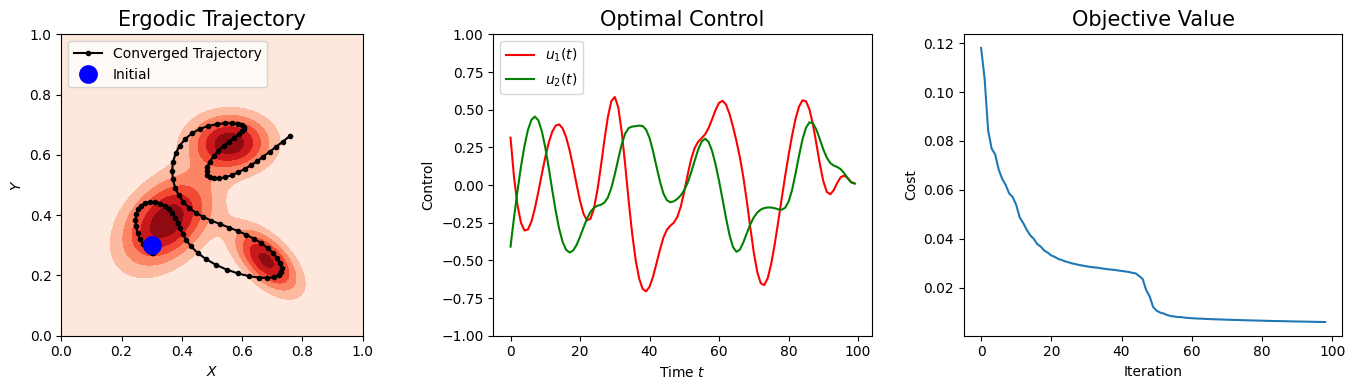

In [64]:
#### Plot everything
phi_recon = reconstruct_pdf(get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj), ks, L_list, grids, dx, dy)

# visualize trajectory
size = 4
fontsize_plots = 15
fig, ax = plt.subplots(1, 3, figsize=(size*3.5, size))

ax[0].set_title('Ergodic Trajectory', fontsize=fontsize_plots)
ax[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='o', color='k', label='Converged Trajectory', markersize=3)
ax[0].contourf(grids_x, grids_y, Z.reshape(grids_x.shape), cmap='Reds', levels=5, alpha=1)
ax[0].plot(x0[0], x0[1], 'bo', label='Initial', markersize = 12.5)

ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_aspect('equal')
ax[0].legend(loc='upper left')

ax[1].set_title('Optimal Control', fontsize=fontsize_plots)
ax[1].plot(u_traj[:,0], color='r', label='$u_1(t)$')
ax[1].plot(u_traj[:,1], color='g', label='$u_2(t)$')
ax[1].set_xlabel('Time $t$')
ax[1].set_ylim([-1, 1])
ax[1].set_ylabel('Control')
ax[1].legend(loc='upper left')

ax[2].set_title('Objective Value', fontsize=fontsize_plots)
ax[2].plot(cost_to_go[1:100], color='C0', label='Final Cost: {:.2f}'.format(cost_to_go[-1]))
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Cost')

"""
ax[3].set_xlim(0.0, L_list[0])
ax[3].set_ylim(0.0, L_list[1])
ax[3].set_title('Empirical Distribution')
ax[3].contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax[3].set_aspect('equal')
"""

plt.tight_layout()
plt.savefig('ergodic2.png')
plt.show()
plt.close()

## Task 3

In [45]:
#### Setup
## PDF:
w = np.array([0.5, 0.2, 0.3])
mu = np.array([[0.35, 0.38], [0.68, 0.25], [0.56, 0.64]])
sigma = np.array([[[0.01, 0.004], [0.004, 0.01]], [[0.005, -0.003], [-0.003, 0.005]], [[0.008, 0], [0, 0.004]]])

## Fourier Vector Grid:
num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(np.arange(num_k_per_dim), np.arange(num_k_per_dim))
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T 

## Grid:
L_list = np.array([1.0, 1.0])
N = 100
grids_x, grids_y = np.meshgrid(np.linspace(0, L_list[0], N), np.linspace(0, L_list[1], N))
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (N-1)
dy = 1.0 / (N-1)  # the resolution of the grids

### define parameters
dt, t_end = 0.1, 10
tsteps = int(t_end/dt)
x0 = np.array([0.3, 0.3, np.pi/2])
t = np.linspace(0, t_end, tsteps)

np.seed = 5
init_u_traj = np.tile(np.array([0.05, -np.pi/5]), reps=(tsteps,1))

f1, f2 = 0.1, 5
cosine_signal = np.cos(f1*t) + np.cos(f2*t)
#init_u_traj = -np.tile(cosine_signal[:, np.newaxis], reps=(1, 2))
#init_u_traj[:,0] = 0.01

Q_x = 0.1
R_u = np.diag([0.005, 0.005])

Q_z = np.diag([0.005, 0.005, 0.0025])
R_v = np.diag([0.005, 0.0025])

lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)

In [46]:
#### Function Definitions
## Mixture PDF
def pdf(x):
    return w[0] * mvn.pdf(x, mu[0], sigma[0]) + \
           w[1] * mvn.pdf(x, mu[1], sigma[1]) + \
           w[2] * mvn.pdf(x, mu[2], sigma[2])

## get fourier coefficients
def get_coefficients(pdf, dx, dy, ks, L_list, grids):
    # Compute the coefficients
    coefficients = np.zeros(ks.shape[0])  # number of coefficients matches the number of index vectors
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the fourier basis function over all the grid cells
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  # we use NumPy's broadcasting feature to simplify computation
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)  # normalization term
        fk_vals /= hk

        # step 2: evaluate the spatial probabilty density function over all the grid cells
        pdf_vals = pdf(grids)  # this can computed ahead of the time

        # step 3: approximate the integral through the Riemann sum for the coefficient
        phik = np.sum(fk_vals * pdf_vals) * dx * dy
        coefficients[i] = phik
    return coefficients

## get trajectory coefficients
def get_traj_coefficients(dx, dy, ks, L_list, grids, s_traj):
    if len(s_traj.shape) == 1:
        s_traj = s_traj.reshape(-1, 1)
    traj_coefficients = np.zeros(ks.shape[0])
    s_traj = s_traj[:, :2]
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the basis function over the trajectory
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * s_traj), axis=1)
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        fk_vals /= hk

        # step 2: approximate the integral through the Riemann sum for the coefficient
        ck = np.sum(fk_vals) * dt / (tsteps * dt)
        traj_coefficients[i] = ck
    return traj_coefficients

## reconstruct the pdf
def reconstruct_pdf(coefficients, ks, L_list, grids, dx, dy):
    pdf_recon = np.zeros(grids.shape[0])
    for i, (phik, k_vec) in enumerate(zip(coefficients, ks)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk

        pdf_recon += phik * fk_vals
    return pdf_recon

## reconstruct the trajectory
def reconstruct_traj(traj_coefficients, ks, L_list, dx, dy):
    phi_recon = np.zeros(grids.shape[0])
    for i, (ck, k_vec) in enumerate(zip(traj_coefficients, ks)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk

        phi_recon += ck * fk_vals
    return phi_recon

## ergodic loss:
def ergodic_metric(coefficients, traj_coefficients):
    # Finally, we compute the erogdic metric
    erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coefficients))
    return erg_metric

coefficients = get_coefficients(pdf, dx, dy, ks, L_list, grids)
Z = pdf(grids)

In [47]:
#### LQR Functions
def dyn(xt, ut):
    xdot = np.array([np.cos(xt[2])*ut[0],
                     np.sin(xt[2])*ut[0],
                     ut[1]])
    return xdot


def get_A(t, xt, ut):
    A = np.array([[0, 0, -np.sin(xt[2])*ut[0]],
                  [0, 0, np.cos(xt[2])*ut[0]],
                  [0, 0, 0]])
    return A


def get_B(t, xt, ut):
    B = np.array([[np.cos(xt[2]), 0],
                  [np.sin(xt[2]), 0],
                  [0, 1]])
    return B


def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    return xt_new


def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 3))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new.copy()
        xt = xt_new.copy()
    return x_traj


def a(t, xt, ut, coefficients_difference):
    a_vec = np.zeros((ks.shape[0], 3))
    for i, k_vec in enumerate(ks):
        # step 1: evaluate the basis function over the trajectory
        dfk_vals = np.array([-np.sin(np.pi * k_vec[0]/L_list[0] * xt[0])*np.cos(np.pi * k_vec[1]/L_list[1]* xt[1])*np.pi*k_vec[0]/L_list[0],
                            -np.cos(np.pi * k_vec[0]/L_list[0] * xt[0])*np.sin(np.pi * k_vec[1]/L_list[1]* xt[1])*np.pi*k_vec[1]/L_list[1], 
                            0])
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        dfk_vals /= hk
        a_vec[i] = lamk_list[i] * 2 *(coefficients_difference[i])*dfk_vals/t_end
       
    return Q_x*np.sum(a_vec, axis=0)

def b(t, xt, ut):
    dvec = R_u @ ut
    return dvec


def get_J(x_traj, u_traj):
    J = 0
    J += Q_x*ergodic_metric(coefficients, get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj))
    for t in range(tsteps):
        J += 0.5 * u_traj[t].T @ R_u @ u_traj[t]*dt

    return J

In [48]:
#### ILQR Iteration
def ilqr_iter(x0, u_traj, traj_coefficients, coefficients_difference):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 3, 3))
    B_list = np.zeros((tsteps, 3, 2))
    a_list = np.zeros((tsteps, 3))
    b_list = np.zeros((tsteps, 2))
    
    for t_idx in range(tsteps):
        t = t_idx * dt
        t_idx = np.clip(t_idx, 0, tsteps-1)
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = a(t, x_traj[t_idx], u_traj[t_idx], coefficients_difference)
        b_list[t_idx] = b(t, x_traj[t_idx], u_traj[t_idx])
    
    
    def zp_dyn(t, zp):
        t_idx = (t/dt).astype(int)
        t_idx = np.clip(t_idx, 0, tsteps-1)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        M_11 = At
        M_12 = -Bt@np.linalg.inv(R_v)@Bt.T
        M_21 = -Q_z
        M_22 = -At.T
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        m_1 = -Bt @ np.linalg.inv(R_v) @ bt
        m_2 = -at
        dyn_vec = np.hstack([m_1, m_2])
        
        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((6, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        return np.array([zp_0[0], zp_0[1], zp_0[2], zp_T[3], zp_T[4], zp_T[5]])

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    tlist = np.arange(tsteps) * dt
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((6, tsteps)),
        max_nodes=100
    )
    zp_traj = res.sol(tlist).T
    
    z_traj = zp_traj[:,:3]
    p_traj = zp_traj[:,3:]

    v_traj = np.zeros((tsteps, 2))
    DJ_vt = 0
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]
        
        vt = -np.linalg.inv(R_v) @ (Bt.T @ pt + bt)
        v_traj[_i] = vt
        
        DJ_vt += at.T @ zt + bt.T @ vt
    
    return v_traj, DJ_vt

In [49]:
# Start iLQR iterations here
u_traj = init_u_traj.copy()
x_initial = traj_sim(x0, u_traj)
cost_to_go = np.array(0)
for iter in range(150):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)
    cost_to_go = np.append(cost_to_go, get_J(x_traj, u_traj))
    traj_coefficients = get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj)
    coefficients_difference = traj_coefficients - coefficients
    
    # check for convergence
    """
    if np.abs(cost_to_go[-1] - cost_to_go[-2]) < 1e-8:
        break
        """
    # get descent direction
    v_traj, DJ_vt = ilqr_iter(x0, u_traj, traj_coefficients, coefficients_difference)
    
    # Armijo line search parameters
    gamma = 0.125 # initial step size
    alpha = 1e-02
    beta = 0.5
    
    ### Implement Armijo line search here to update step size gamma
    J_new = get_J(traj_sim(x0, u_traj + gamma*v_traj), u_traj + gamma*v_traj)
    while J_new > cost_to_go[-1] + alpha*gamma*DJ_vt:
        gamma = beta*gamma
        J_new = get_J(traj_sim(x0, u_traj + gamma*v_traj), u_traj + gamma*v_traj)
    
    # update control for the next iteration
    u_traj += gamma * v_traj #+ gamma* 0.01*np.random.randn(tsteps, 2)
    print('Iteration:', iter, 'Cost:', cost_to_go[-1], 'Step Size:', gamma)

cost_to_go[0] = cost_to_go[1]

Iteration: 0 Cost: 0.14502367790854714 Step Size: 0.0078125
Iteration: 1 Cost: 0.06596317781493659 Step Size: 0.03125
Iteration: 2 Cost: 0.048772596978326116 Step Size: 0.015625
Iteration: 3 Cost: 0.03395614034082787 Step Size: 0.0078125
Iteration: 4 Cost: 0.02986899589182971 Step Size: 0.03125
Iteration: 5 Cost: 0.028797623376008916 Step Size: 0.0078125
Iteration: 6 Cost: 0.026967998405991917 Step Size: 0.0625
Iteration: 7 Cost: 0.02555205203151199 Step Size: 0.0078125
Iteration: 8 Cost: 0.024229492079737583 Step Size: 0.015625
Iteration: 9 Cost: 0.023906198172627936 Step Size: 0.0078125
Iteration: 10 Cost: 0.023508125272259216 Step Size: 0.015625
Iteration: 11 Cost: 0.023151452862429308 Step Size: 0.0078125
Iteration: 12 Cost: 0.022855409524393983 Step Size: 0.03125
Iteration: 13 Cost: 0.02240637581862927 Step Size: 0.0078125
Iteration: 14 Cost: 0.021806098281413486 Step Size: 0.015625
Iteration: 15 Cost: 0.02145732276785759 Step Size: 0.015625
Iteration: 16 Cost: 0.02124694691619638

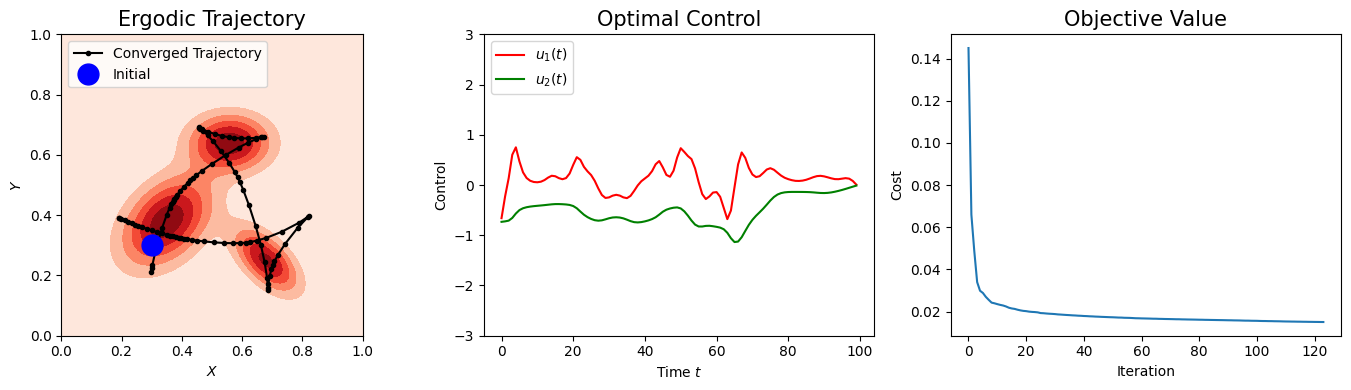

In [57]:
#### Plot everything
phi_recon = reconstruct_pdf(get_traj_coefficients(dx, dy, ks, L_list, grids, x_traj), ks, L_list, grids, dx, dy)

# visualize trajectory
size = 4
fontsize_plots = 15
fig, ax = plt.subplots(1, 3, figsize=(size*3.5, size))

ax[0].set_title('Ergodic Trajectory', fontsize=fontsize_plots)
ax[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='o', color='k', label='Converged Trajectory', markersize=3)
ax[0].contourf(grids_x, grids_y, Z.reshape(grids_x.shape), cmap='Reds', levels=5, alpha=1)
ax[0].plot(x0[0], x0[1], 'bo', label='Initial', markersize = 15)
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_aspect('equal')
ax[0].legend(loc='upper left')


ax[1].set_title('Optimal Control', fontsize=fontsize_plots)
ax[1].plot(u_traj[:,0], color='r', label='$u_1(t)$')
ax[1].plot(u_traj[:,1], color='g', label='$u_2(t)$')
ax[1].set_xlabel('Time $t$')
ax[1].set_ylim([-3, 3])
ax[1].set_ylabel('Control')
ax[1].legend(loc='upper left')

ax[2].set_title('Objective Value', fontsize=fontsize_plots)
ax[2].plot(cost_to_go[1:125], color='C0', label='Final Cost: {:.2f}'.format(cost_to_go[-1]))
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Cost')

"""
ax[3].set_aspect('equal')
ax[3].set_xlim(0.0, L_list[0])
ax[3].set_ylim(0.0, L_list[1])
ax[3].set_title('Empirical Distribution')
ax[3].contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax[3].set_aspect('equal')
"""

plt.tight_layout()
plt.savefig('ergodic3.png')
plt.show()
plt.close()